In [37]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data16317


In [38]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

housing.data


In [39]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 122kB 20.4MB/s eta 0:00:01


In [40]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [41]:
#导入相关的库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [42]:
# 编写加载数据的函数
def load_data():
    # 从文件导入数据
    datafile='./work/housing.data'
    data=np.fromfile(datafile,sep=' ',dtype=np.float32)
    
    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    #将一维的数据转成二维
    data = data.reshape([data.shape[0] // feature_num, feature_num])
    
    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio=0.8
    offset=int(data.shape[0]*ratio)
    training_data=data[:offset]

    # 计算train数据集的最大值，最小值，平均值
    maximums,minimums,avgs=training_data.max(axis=0),training_data.min(axis=0),training_data.sum(axis=0)/training_data.shape[0]

    # 记录数据的归一化参数，在预测时对数据做归一化
    global max_values
    global min_values
    global avg_values
    max_values=maximums
    min_values=minimums
    avg_values=avgs

    # 对数据进行归一化处理
    for i in range(feature_num):
        data[:,i]=(data[:,i]-avgs[i])/(maximums[i]-minimums[i])

    # 训练集和测试集的划分比例
    training_data=data[:offset]
    test_data=data[offset:]
    
    return training_data,test_data

In [43]:
# 定义网络结构为两层，全连接层+激活函数+全连接层
class Net(paddle.nn.Layer):
    # self代表类的实例自身
    def __init__(self):
        # 初始化父类中的一些参数
        super(Net,self).__init__()

        self.fc1=Linear(in_features=13,out_features=128)
        self.fc2=Linear(in_features=128,out_features=1)
        
    def forward(self,inputs):
        x=self.fc1(inputs)
        x=F.relu(x)
        x=self.fc2(x)
        return x

In [44]:
#创建网络的一个对象
model=Net()
model.train()
#进入模型的训练模式
training_data, test_data = load_data()
opt = paddle.optimizer.Adam(learning_rate=0.01, parameters=model.parameters())
#设置优化器为Adam

In [45]:
EPOCH_NUM = 100   #设置迭代次数
BATCH_SIZE = 10  #设置批次大小

# 定义外层循环
losses=[]
for epoch_id in range(1,EPOCH_NUM+1):
    # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
    np.random.shuffle(training_data)
    # 将训练数据进行拆分，每个batch包含10条数据
    mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
    # 定义内层循环
    for iter_id, mini_batch in enumerate(mini_batches):
        x = np.array(mini_batch[:, :-1]) # 获得当前批次训练数据
        y = np.array(mini_batch[:, -1:]) # 获得当前批次训练标签（真实房价）
        # 将numpy数据转为飞桨动态图tensor形式
        house_features = paddle.to_tensor(x)
        prices = paddle.to_tensor(y)
        
        # 前向计算
        predicts = model(house_features)
        
        # 计算损失
        loss = F.square_error_cost(predicts, label=prices)
        avg_loss = paddle.mean(loss)
        losses.append(avg_loss.numpy())
        if iter_id % 20==0:
            print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, avg_loss.numpy()))
        
        # 反向传播
        avg_loss.backward()
        # 最小化loss,更新参数
        opt.step()
        # 清除梯度
        opt.clear_grad()

epoch: 1, iter: 0, loss is: [0.02875786]
epoch: 1, iter: 20, loss is: [0.01014329]
epoch: 1, iter: 40, loss is: [0.00580197]
epoch: 2, iter: 0, loss is: [0.00517416]
epoch: 2, iter: 20, loss is: [0.00755648]
epoch: 2, iter: 40, loss is: [0.00383944]
epoch: 3, iter: 0, loss is: [0.0033968]
epoch: 3, iter: 20, loss is: [0.00634085]
epoch: 3, iter: 40, loss is: [0.00484461]
epoch: 4, iter: 0, loss is: [0.00301662]
epoch: 4, iter: 20, loss is: [0.00820194]
epoch: 4, iter: 40, loss is: [0.00469439]
epoch: 5, iter: 0, loss is: [0.00098433]
epoch: 5, iter: 20, loss is: [0.00840407]
epoch: 5, iter: 40, loss is: [0.00357361]
epoch: 6, iter: 0, loss is: [0.00463749]
epoch: 6, iter: 20, loss is: [0.00470148]
epoch: 6, iter: 40, loss is: [0.00227926]
epoch: 7, iter: 0, loss is: [0.00078318]
epoch: 7, iter: 20, loss is: [0.0062756]
epoch: 7, iter: 40, loss is: [0.00940356]
epoch: 8, iter: 0, loss is: [0.00267786]
epoch: 8, iter: 20, loss is: [0.00360906]
epoch: 8, iter: 40, loss is: [0.00121929]
ep

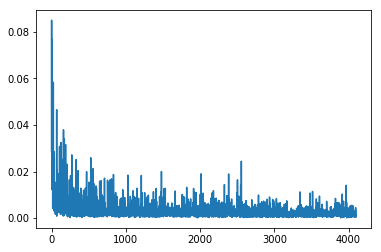

In [46]:
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

In [47]:
# 保存模型参数，文件名为LR_model.pdparams
paddle.save(model.state_dict(), 'LR_model.pdparams')
print("模型保存成功，模型参数保存在LR_model.pdparams中")

模型保存成功，模型参数保存在LR_model.pdparams中


In [48]:
# 参数为保存模型参数的文件地址
model_dict = paddle.load('LR_model.pdparams')
model.load_dict(model_dict)
model.eval()

# 从上边已加载的测试集中，随机选择一条作为测试数据
idx = np.random.randint(0, test_data.shape[0])
one_data, label = test_data[idx, :-1], test_data[idx, -1]
# 修改该条数据shape为[1,13]
one_data =  one_data.reshape([1,-1])

# 将数据转为动态图的variable格式 
one_data = paddle.to_tensor(one_data)
predict = model(one_data)

# 对结果做反归一化处理
predict = predict * (max_values[-1] - min_values[-1]) + avg_values[-1]
# 对label数据做反归一化处理
label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]

print("Inference result is {}, the corresponding label is {}".format(predict.numpy(), label))

Inference result is [[25.91603]], the corresponding label is 23.899999618530273
